## Import Libraries

In [4]:
cd /content/drive/MyDrive/garbage_sorting data

/content/drive/MyDrive/garbage_sorting data


In [5]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from PIL import Image, ImageOps, ImageEnhance
from tensorflow.keras.models import Sequential
from keras.layers import Activation, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from skimage.transform import resize
import keras.utils as ku
import random

## Read images and transform the data

In [6]:

#* setting absolute path  for the project as base_dir
base_dir = os.path.abspath('.')
#* collecting data
original_img_dir = Path(base_dir,'TrashType_Image_Dataset')
transformer = T.Compose([T.Resize((32,32)), T.ToTensor()])
dataset = ImageFolder(original_img_dir, transform= transformer)

print(dataset.classes)

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


## distribution of files by class

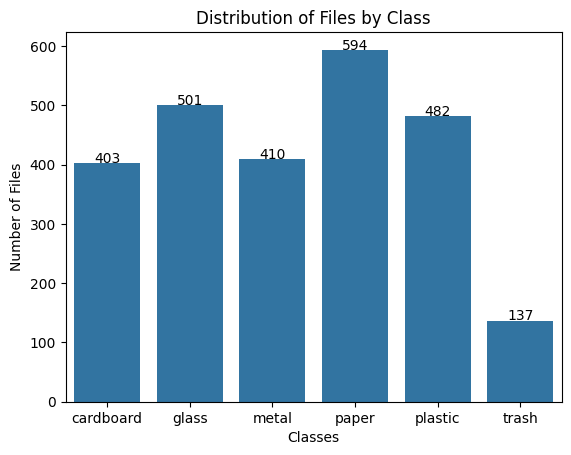

In [7]:
def count_files(directory):
    """
    This function takes a directory path as input and returns the number of files in that directory.
    """
    only_files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
    return len(only_files)

classes_and_count = {}
# Example usage:
for claass in dataset.classes:
    directory = Path(original_img_dir, claass)
    classes_and_count[claass] = count_files(directory)
sns.barplot(x=list(classes_and_count.keys()), y=list(classes_and_count.values()))
plt.xlabel('Classes')
plt.ylabel('Number of Files')
plt.title('Distribution of Files by Class')
for i, v in enumerate(classes_and_count.values()):
    plt.text(i, v+0.5, str(v), ha='center')

plt.show()

## split and store the data into train and test data

In [8]:

#* generating gray and resized images
for claass in dataset.classes:
    image_path_org = Path(base_dir,'TrashType_Image_Dataset', claass)
    image_path_gray = Path(base_dir,'processed trashtype_image_dataset',claass)
    list_files = os.listdir(image_path_org)
    for file in list_files:
        read_img = Image.open(os.path.join(image_path_org, file))
        img = read_img.resize((32,32))
        gray = img.convert('L')
        gray.save(os.path.join(image_path_gray, file), "JPEG")

In [9]:

#* entering train nad test directories path in variables
train_dir = os.path.join(base_dir, 'processed trashtype_image_dataset')
test_dir = os.path.join(base_dir, 'TrashType_Image_Dataset')

In [10]:

#* it can easily transform the image to range from range 0,255 to 0,1
image_gen = ImageDataGenerator(rescale=1./255)

train_data_gen = image_gen.flow_from_directory(
    directory = train_dir,
    shuffle=True,
    target_size = (32, 32),
    class_mode='categorical')

test_data_gen = image_gen.flow_from_directory(
    directory = test_dir,
    shuffle=True,
    target_size = (32, 32),
    class_mode='categorical')

Found 2527 images belonging to 6 classes.
Found 2527 images belonging to 6 classes.


## Builing the Neural Network

In [11]:
model = Sequential([
    Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=(32,32, 3)),
    MaxPooling2D(pool_size=2),

    Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
    MaxPooling2D(pool_size=2),

    Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'),
    MaxPooling2D(pool_size=2),

    Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'),
    MaxPooling2D(pool_size=2),

    Flatten(),

    Dense(6, activation='softmax')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## setting up training parameters

In [12]:
batch_size = 40
epochs = 60
model.compile(optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 8, 8, 32)            │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 4, 4, 32)            │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 2, 2, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 47,878 (187.02 KB)

 Trainable params: 47,878 (187.02 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
num_cardboard_train = len(os.listdir(Path(base_dir,'TrashType_Image_Dataset', 'cardboard')))
num_glass_train = len(os.listdir(Path(base_dir,'TrashType_Image_Dataset', 'glass')))
num_metal_train = len(os.listdir(Path(base_dir,'TrashType_Image_Dataset', 'metal')))
num_paper_train = len(os.listdir(Path(base_dir,'TrashType_Image_Dataset', 'paper')))
num_plastic_train = len(os.listdir(Path(base_dir,'TrashType_Image_Dataset', 'plastic')))
num_trash_train = len(os.listdir(Path(base_dir,'TrashType_Image_Dataset', 'trash')))

num_cardboard_test = len(os.listdir(Path(base_dir, 'processed trashtype_image_dataset', 'cardboard')))
num_glass_test = len(os.listdir(Path(base_dir, 'processed trashtype_image_dataset', 'glass')))
num_metal_test = len(os.listdir(Path(base_dir, 'processed trashtype_image_dataset', 'metal')))
num_paper_test = len(os.listdir(Path(base_dir, 'processed trashtype_image_dataset', 'paper')))
num_plastic_test = len(os.listdir(Path(base_dir, 'processed trashtype_image_dataset', 'plastic')))
num_trash_test = len(os.listdir(Path(base_dir, 'processed trashtype_image_dataset', 'trash')))

total_train = sum((num_cardboard_train , num_glass_train , num_metal_train , num_paper_train , num_plastic_train , num_trash_train))
total_test = sum((num_cardboard_test , num_glass_test , num_metal_test , num_paper_test , num_plastic_test , num_trash_test))

print(f"number of total_test: {total_test}\nnumber of total_train: {total_train}")

number of total_test: 2527
number of total_train: 2527


In [14]:
history = model.fit(
    train_data_gen,
    validation_data = train_data_gen,
    steps_per_epoch= total_train // batch_size,
    epochs = epochs,
    validation_steps= total_test // batch_size,
    callbacks = [tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                min_delta=0.01,
                patience=7)]
)

Epoch 1/60


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


63/63 ━━━━━━━━━━━━━━━━━━━━ 30s 420ms/step - accuracy: 0.2393 - loss: 1.7443 - val_accuracy: 0.2376 - val_loss: 1.7031
Epoch 2/60
16/63 ━━━━━━━━━━━━━━━━━━━━ 6s 136ms/step - accuracy: 0.2239 - loss: 1.6907

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - accuracy: 0.2291 - loss: 1.6888 - val_accuracy: 0.2740 - val_loss: 1.6903
Epoch 3/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 27s 418ms/step - accuracy: 0.2461 - loss: 1.6786 - val_accuracy: 0.2976 - val_loss: 1.5945
Epoch 4/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - accuracy: 0.3168 - loss: 1.5654 - val_accuracy: 0.2877 - val_loss: 1.5307
Epoch 5/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 36s 408ms/step - accuracy: 0.3540 - loss: 1.5417 - val_accuracy: 0.4092 - val_loss: 1.4638
Epoch 6/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - accuracy: 0.4375 - loss: 1.4657 - val_accuracy: 0.4149 - val_loss: 1.4761
Epoch 7/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 27s 407ms/step - accuracy: 0.4171 - loss: 1.4509 - val_accuracy: 0.4727 - val_loss: 1.3387
Epoch 8/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - accuracy: 0.4741 - loss: 1.3257 - val_accuracy: 0.4325 - val_loss: 1.3942
Epoch 9/60
63/63 ━━━━━━━━━━━━━━━━━━━━ 34s 373ms/step - accuracy: 0.4482 - loss: 1.3900 - val_accuracy: 0.5154 - val_

In [15]:
test_loss, test_acc = model.evaluate(test_data_gen)
print(f'Test accuracy: {test_acc*100}, Test Loss: {test_loss}')

79/79 ━━━━━━━━━━━━━━━━━━━━ 19s 243ms/step - accuracy: 0.7833 - loss: 0.6665
Test accuracy: 78.51207256317139, Test Loss: 0.6571850180625916


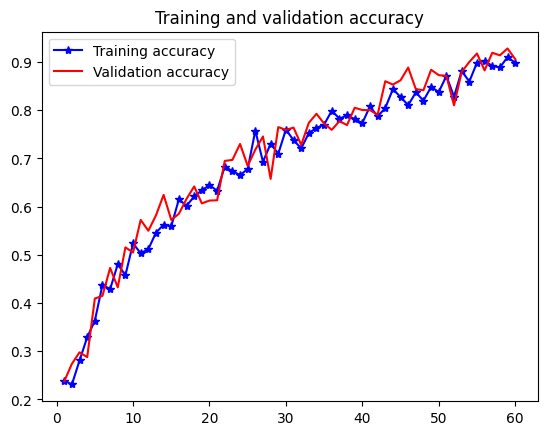

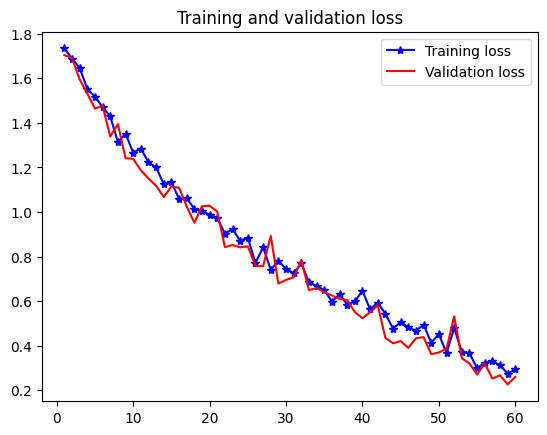

In [16]:
train_acc = history.history['accuracy'] # store training accuracy in history
val_acc = history.history['val_accuracy'] # store validation accuracy in history
train_loss = history.history['loss'] # store training loss in history
val_loss = history.history['val_loss'] # store validation loss in history

epochs = range(1, len(train_acc) + 1)

plt.plot(epochs, train_acc, 'b*-', label = 'Training accuracy')
plt.plot(epochs, val_acc, 'r', label = 'Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, train_loss, 'b*-', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Testing prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
Glass picture number : 62
Truth : glass
Probability: 97.74%
Classified: glass 



Text(0.5, 1.0, 'Loaded Image')

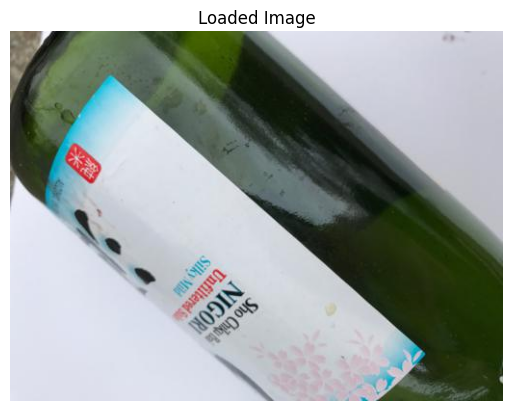

In [20]:
random_class = random.choice(dataset.classes)
random_num = random.randint(0, classes_and_count[random_class])
random_num_str = str(random_num).zfill(3)

test_img_path = Path(base_dir,'TrashType_Image_Dataset',random_class)
test_img = f'{test_img_path}/{random_class}_{random_num_str}.jpg'
show_img = ku.load_img(test_img)
img = ku.load_img(test_img, target_size = (32,32))
img = ku.img_to_array(img, dtype=np.uint8)
img = np.array(img)/255.0
prediction = model.predict(img[np.newaxis,...])

#print("Predicted shape",p.shape)
print(f"{random_class.title()} picture number : {random_num}")
print(f"Truth : {random_class}")
print("Probability: {:.2f}%".format(np.max(prediction[0], axis=-1) * 100))
predicted_class = dataset.classes[np.argmax(prediction[0], axis=-1)]
print("Classified:",predicted_class,'\n')

plt.axis('off')
plt.imshow(show_img)
plt.title("Loaded Image")

In [19]:
ls

'processed trashtype_image_dataset'/   TrashType_Image_Dataset/
